## Instructions : Which Novel Do I Belong To?

In [217]:
!cat "instructions.txt"

Which Novel Do I Belong To?

In this task, you are expected to learn a Machine Learning model that classifies a given line as belonging to one of the following 12 novels:

0: alice_in_wonderland
1: dracula
2: dubliners
3: great_expectations
4: hard_times
5: huckleberry_finn
6: les_miserable
7: moby_dick
8: oliver_twist
9: peter_pan
10: talw_of_two_cities
11: tom_sawyer


Description:

You are provided a zip file (challenge_data_for_applicants.zip) containing three text files - xtrain.txt, ytrain.txt, xtest.txt. Each line in xtrain.txt comes from a different novel. The corresponding novel ids are specified in ytrain.txt. You can use this data to train a Machine Learning model (Deep Learning preferred).

With the learned model, predict the novel ids of the lines in xtest.txt (one prediction per line). As part of your submission, include

a) your predictions (in the same format as ytrain.txt)
b) the source code for training and prediction
c) a brief description of the used method (optiona

# Introduction
In this challenge, I created a module to manage coding in Jupyter Notebook, easily since I want to use visualization feature of the notebook. The module name is 'Novel.py'. It has a bunch of public, private and static methods. Throughout this experiment, I will expose the details of the implementation.

The experiment consists of a few steps, below
+ Preprocesing : Data cleansing, Feature engineering
+ Data Visualization
+ Building word2vec model
+ Building Deep Learning Layer
+ Performance Evaluation
+ Tuning according to results

Those steps can find in the method __build_model() in the module Novel.py.

    def __build_model(self):

        self.__create_clean_token_corpus()
        self.__create_word2vec()
        self.__create_token_vectors()
        self.__create_sequences()
        self.__create_embedding_matrix()
        self.__create_nn()
        
        


## Solution (Novel.py)

In [ ]:
# %load Novel.py
import os.path
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
import gensim, logging
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from functools import reduce

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.models import Sequential

from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer


default_label_names = {0: "alice_in_wonderland", 1: "dracula", 2: "dubliners", 3: "great_expectations",
                       4: "hard_times", 5: "huckleberry_finn", 6: "les_miserable", 7: "moby_dick",
                       8: "oliver_twist", 9: "peter_pan", 10: "tale_of_two_cities", 11: "tom_sawyer"}


class Novel:

    # Spacy library is loading English dictionary.
    __nlp = spacy.load("en")
    __symbol_list = None

    # To implement a processing chain global variables were used.
    # Since I have a limited time I preferred approach rather than using pipeline libs in Pyhton
    # The other reason is that I would like to used them in visualization on Jupyter Notebook
    __clean_tokens = None
    __clean_corpus = None
    __word2vec = None
    __tokenizer = None
    __train_tokens_vector = None
    __test_tokens_vector = None
    __x_train_ps = None  # pad_sequences
    __x_test_ps = None  # pad_sequences
    __embedding_matrix = None
    __nn = None
    labelled_pas = None

    # To create word2vec, the parameters are used in Gensim
    # There are a few different sources instead of creating our word2vec model,
    # + Google's pre-trained vectors based on GoogleNews
    # + GLoVe's pre-trained vectors based on Wikipages
    # + Spacy pre-trained vectors
    __embedding_dim = 300
    __window = 10
    __workers = 4
    __cbow_mean = 1
    __alpha = 0.05

    # Creating an embedding matrix using by word2vec model and the parameters, below
    __embedding_vector_length = 300
    __max_nb_words = 200000
    __max_input_length = 50

    # Deep Learning Layers' parameters are using to build a deep network. Our network consists of the layers, below:
    # + Embedding Layer
    # + Dense Layer
    # + LSTM for RNN Layer
    # + Dense Layer
    __num_lstm = 100
    __num_dense = 300
    __rate_drop_out = 0.2
    __rate_drop_lstm = float(0.15 + np.random.rand() * 0.25)
    __rate_drop_dense = float(0.15 + np.random.rand() * 0.25)

    # Creating file names for models with respect to given parameters, above.
    __format_word2vec_model = "emb_dim:{}_window:{}_cbow:{}_apha:{}.bin"
    __format_dl_model = 'lstm_%d_%d_%.2f_%.2f.h5'

    __word2vec_file = __format_word2vec_model.format(__embedding_dim, __window, __cbow_mean, __alpha)
    __model_dl_file = __format_dl_model % (__num_lstm, __num_dense, __rate_drop_lstm, __rate_drop_dense)

    # In training step, those parameters are using, below.
    __epochs = 100
    __batch_size = 2048
    __validation_split = 0.1
    __shuffle = True

    def __init__(self,
                 x_train_file,
                 y_train_file,
                 x_test_file,
                 x_name="raw_passage",
                 y_name="novel_id",
                 label_names = default_label_names):

        self.__label_names = label_names
        self.__x_name = x_name
        self.__y_name = y_name
        self.__num_classes = len(self.__label_names)
        self.__df_raw_xtrain = pd.read_fwf(x_train_file, header=None, names=[x_name], encoding="utf-8")
        self.__df_raw_ytrain = pd.read_fwf(y_train_file, header=None, names=[y_name], encoding="utf-8")
        self.__df_raw_xtest = pd.read_fwf(x_test_file, header=None, names=[x_name], encoding="utf-8")
        self.__raw_corpus = self.__df_raw_xtrain[x_name].values.tolist() + self.__df_raw_xtest[x_name].values.tolist()

        # https://keras.io/utils/#to_categorical
        self.__y_train_one_hot = to_categorical(self.__df_raw_ytrain[y_name].values, self.__num_classes)

    def head(self):
        print(self.__df_raw_xtrain.head())
        print(self.__df_raw_ytrain.head())
        print(self.__df_raw_xtest.head())

    def describe(self):
        print(self.__label_names)
        print(self.__df_raw_xtrain.describe())
        print(self.__df_raw_ytrain.describe())
        print(self.__df_raw_xtest.describe())
        print("y_train_one_hot: {}".format(self.__y_train_one_hot.shape))

    # Finding symbols and punctuations in the corpus, which consists of train and test data
    @staticmethod
    def __find_syms_puncs_in_corpus(corpus):
        symbol_sets = list(
                map(lambda pas: set(filter(lambda ch: (not ch.isalnum() and not ch.isspace()), pas)), corpus))
        return reduce((lambda lhs_sym, rhs_sym: lhs_sym.union(rhs_sym)), symbol_sets)

    # Converting all characters to lower case
    @staticmethod
    def __lower_case(corpus):
        return list(map(lambda pas: pas.lower(), corpus))

    # Adding extra space around of the symbols and punctuations in the corpus
    @staticmethod
    def __add_space_syms_puncs(corpus, symbols):
        for sym in symbols:  # string.punctuation:
            corpus = list(map(lambda pas: pas.replace(sym, " {} ".format(sym)) if sym in pas else pas, corpus))
        return corpus

    # Removing consecutive whitespaces in the corpus
    @staticmethod
    def __remove_consecutive_spaces(corpus):
        return list(map(lambda pas: " ".join(pas.split()), corpus))

    # Removing symbols and punctuations in the corpus
    def __clean_punc(self, corpus):
        processed_corpus = []
        for pas in corpus:
            processed_pas = self.__nlp(pas)
            tmp_pas = ["" if token.is_stop or token.is_punct else token.orth_ for i, token in enumerate(processed_pas)]
            tmp_pas = list(filter(lambda tok: tok is not "", tmp_pas))
            processed_corpus.append(tmp_pas)

        return processed_corpus

    def __clean_raw_corpus(self, corpus):

        print("The raw corpus is being cleaned...")

        tmp_corpus = self.__lower_case(corpus)
        tmp_corpus = self.__add_space_syms_puncs(tmp_corpus, self.__symbol_list)
        tmp_corpus = self.__remove_consecutive_spaces(tmp_corpus)

        t = self.__clean_punc(tmp_corpus)
        c = list(map(lambda pas: " ".join(pas), t))

        print("The raw corpus was cleaned!")

        return t, c

    def __create_clean_token_corpus(self):

        if self.__clean_tokens is not None and self.__clean_corpus is not None:
            print("clean_token and clean_corpus already have been calculated and loaded...")
            return

        if self.__symbol_list is None:
            self.__symbol_list = self.__find_syms_puncs_in_corpus(self.__raw_corpus)

        print("symbol_list : {}".format(self.__symbol_list))

        self.__clean_tokens, self.__clean_corpus = self.__clean_raw_corpus(self.__raw_corpus)

    def __create_word2vec(self):
        logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

        if not os.path.exists(self.__word2vec_file) or self.__word2vec is None:
            print("{} doesn't exist. A new word2vec is being built...".format(self.__word2vec_file))
            self.__word2vec = gensim.models.Word2Vec(self.__clean_tokens,
                                                 size=self.__embedding_dim,
                                                 window=self.__window,
                                                 workers=self.__workers,
                                                 cbow_mean=self.__cbow_mean,
                                                 alpha=self.__alpha)

            self.__word2vec.save(self.__word2vec_file)

        elif self.__word2vec is not None:
            print("{} has already loaded for word2vec...".format(self.__word2vec_file))
        else:
            print("{} is loading for word2vec...".format(self.__word2vec_file))
            self.__word2vec = gensim.models.Word2Vec.load(self.__word2vec_file)

    def __create_token_vectors(self):

        if self.__train_tokens_vector is not None and self.__test_tokens_vector is not None:
            print("train_token_vectors already have been calculated and loaded...")
            return

        x_train_corpus = self.__clean_corpus[:len(self.__df_raw_xtrain)]
        x_test_corpus = self.__clean_corpus[len(self.__df_raw_xtrain):]

        print("x_train_corpus: {}".format(len(x_train_corpus)))
        print("x_test_corpus: {}".format(len(x_test_corpus)))

        # https://keras.io/preprocessing/text/#tokenizer
        self.__tokenizer = Tokenizer(num_words=self.__max_nb_words)
        self.__tokenizer.fit_on_texts(self.__clean_corpus)

        print('Found %s unique tokens' % len(self.__tokenizer.word_index))

        # https://keras.io/preprocessing/text/#text_to_word_sequence
        self.__train_tokens_vector = self.__tokenizer.texts_to_sequences(x_train_corpus)
        self.__test_tokens_vector = self.__tokenizer.texts_to_sequences(x_test_corpus)

        print("train_tokens_vector: {}".format(len(self.__train_tokens_vector)))
        print("test_tokens_vector: {}".format(len(self.__test_tokens_vector)))

    def __create_sequences(self):

        if self.__x_train_ps is not None and self.__x_test_ps is not None:
            print("pad sequences already have been calculated and loaded...")
            return
        # https://keras.io/preprocessing/sequence/#pad_sequences
        self.__x_train_ps = pad_sequences(self.__train_tokens_vector, maxlen=self.__max_input_length)
        self.__x_test_ps = pad_sequences(self.__test_tokens_vector, maxlen=self.__max_input_length)
        print("x_train_padded: {}".format(self.__x_train_ps.shape))
        print("x_test_padded: {}".format(self.__x_test_ps.shape))

    def __create_embedding_matrix(self):

        if self.__embedding_matrix is not None:
            print("embedding matrix already has been calculated and loaded...")
            return

        token_index = self.__tokenizer.word_index

        number_words = min(self.__max_nb_words, len(token_index)) + 1
        self.__embedding_matrix = np.zeros((number_words, self.__embedding_vector_length))
        for word, i in token_index.items():
            if word in self.__word2vec.wv.vocab:
                self.__embedding_matrix[i] = self.__word2vec.wv.word_vec(word)

        print('Null word embeddings: %d' % np.sum(np.sum(self.__embedding_matrix, axis=1) == 0))
        print("embedding_matrix: {}".format(self.__embedding_matrix.shape))

    def __create_nn(self):

        if self.__nn is not None:
            print("Deep Learning Layers already has been built and loaded...")
            return

        def init_weights(shape, dtype=None):
            print("init_weights shape: {}".format(shape))
            # assert  shape == embedding_matrix.shape
            return self.__embedding_matrix

        self.__nn = Sequential()

        # https://keras.io/layers/embeddings/
        number_words = self.__embedding_matrix[0]
        self.__nn.add(Embedding(number_words,
                            self.__embedding_vector_length,
                            input_length=self.__max_input_length,
                            mask_zero=True,
                            embeddings_initializer=init_weights))

        # https://keras.io/layers/core/#dense
        # https://keras.io/layers/core/#activation
        self.__nn.add(Dense(self.__num_dense, activation='sigmoid'))

        self.__nn.add(Dropout(self.__rate_drop_out))

        # https://keras.io/layers/recurrent/
        self.__nn.add(LSTM(self.__num_lstm, dropout=self.__rate_drop_lstm, recurrent_dropout=self.__rate_drop_lstm))
        self.__nn.add(Dense(self.__num_classes, activation='softmax'))

        # https://keras.io/metrics/
        self.__nn.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
        self.__nn.summary()

    def __build_model(self):

        self.__create_clean_token_corpus()
        self.__create_word2vec()
        self.__create_token_vectors()
        self.__create_sequences()
        self.__create_embedding_matrix()
        self.__create_nn()

    def __create_callbacks(self, tensorboard):

        callbacks = []
        # https://keras.io/callbacks/#usage-of-callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=3)

        print(self.__model_dl_file)
        # https://keras.io/callbacks/#modelcheckpoint
        model_checkpoint = ModelCheckpoint(self.__model_dl_file, save_best_only=True, save_weights_only=True)

        # https://keras.io/callbacks/#tensorboard
        if tensorboard:
            tensor_board = TensorBoard(log_dir='./logs',
                                       histogram_freq=5,
                                       write_graph=True,
                                       write_images=True,
                                       embeddings_freq=0,
                                       embeddings_layer_names=None,
                                       embeddings_metadata=None)
            callbacks.append(tensor_board)

        callbacks.append(early_stopping)
        callbacks.append(model_checkpoint)

        return callbacks

    def train(self, tensorboard_enable=False):

        self.__build_model()

        callbacks = self.__create_callbacks(tensorboard_enable)

        # https://keras.io/models/model/
        hist = self.__nn.fit(self.__x_train_ps,
                             self.__y_train_one_hot,
                             epochs=self.__epochs,
                             batch_size=self.__batch_size,
                             validation_split=self.__validation_split,
                             shuffle=self.__shuffle,
                             callbacks=callbacks)

        self.__nn.load_weights(self.__model_dl_file)

        bst_val_score = min(hist.history['val_loss'])
        bst_val_score

    def test(self, y_test_file="ytest.txt"):
        prediction_probs = self.__nn.predict(self.__x_test_ps,
                                             batch_size=self.__batch_size,
                                             verbose=1)

        pre_label_ids = list(map(lambda probs: probs.argmax(), list(prediction_probs)))

        tmp_df = pd.DataFrame(data=pre_label_ids)
        tmp_df.to_csv(y_test_file, index=False, header=False)
        print("The result was saved into file 'ytest.txt'")

        prediction_labels = list(map(lambda probs: [probs.argmax(), probs.max(), self.__label_names[probs.argmax()]], list(prediction_probs)))
        self.labelled_pas = list(zip(self.__df_raw_xtest[self.__x_name].values.tolist(), prediction_labels))



    def test_by_file(self, x_test_file, y_test_file="ytest.txt"):

        df = pd.read_fwf(x_test_file, header=None, names=[self.__x_name], encoding="utf-8")
        corpus = df[self.__x_name].values.tolist()

        clean_tokens, clean_corpus = self.__clean_raw_corpus(corpus)
        test_tokens_vector = self.__tokenizer.texts_to_sequences(clean_corpus)
        x_test_ps = pad_sequences(test_tokens_vector, maxlen=self.__max_input_length)

        prediction_probs = self.__nn.predict(x_test_ps,
                                             batch_size=self.__batch_size,
                                             verbose=1)

        pre_label_ids = list(map(lambda probs: probs.argmax(), list(prediction_probs)))

        tmp_df = pd.DataFrame(data=pre_label_ids)
        tmp_df.to_csv(y_test_file, index=False, header=False)
        print("The result was saved into file 'ytest.txt'")

        prediction_labels = list(map(lambda probs: [probs.argmax(), probs.max(), self.__label_names[probs.argmax()]],
                                     list(prediction_probs)))
        self.labelled_pas = list(zip(self.__df_raw_xtest[self.__x_name].values.tolist(), prediction_labels))

    def count_words_in_passage(self):
        return list(map(lambda pas: len(pas), self.__clean_tokens))

    def plot_cdf_nb_tokens_in_passage(self):
        p_lens = self.count_words_in_passage()
        x, y = NovelUtil.calculate_cdf(p_lens)

        figure, axes = plt.subplots(1, figsize=(15, 10))
        NovelUtil.plot_cdf(x,
                 y,
                 axes,
                 deltax=5,
                 xlim=[0, np.mean(p_lens) + 3 * np.std(p_lens) + 50],
                 deltay=0.05,
                 ylim=[0, 1.00])

    def plot_sample_word2vec(self):
        figure, axes = plt.subplots(1, figsize=(15, 10))
        wv = [self.__word2vec[k] for k in list(self.__word2vec.wv.vocab.keys())]
        vocabulary = [k for k in list(self.__word2vec.wv.vocab.keys())]

        tsne = TSNE(n_components=2, random_state=0)
        np.set_printoptions(suppress=True)
        Y = tsne.fit_transform(wv[100:150])
        # Y = tsne.fit_transform(wv[idx_list])

        plt.scatter(Y[:, 0], Y[:, 1])
        for label, x, y in zip(vocabulary, Y[:, 0], Y[:, 1]):
            plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
        plt.axes = axes
        plt.show()


class NovelUtil:
    @staticmethod
    def calculate_cdf(x):

        length = len(x)
        y = np.arange(1, length + 1) / float(length)
        return np.array(sorted(x)), y

    @staticmethod
    def plot_cdf(x,
                 y,
                 ax,
                 deltax=None,
                 xlog=False,
                 xlim=[0, 1],
                 deltay=0.25, ylog=False,
                 ylim=[0, 1],
                 font_size=12):

        if deltax is not None:
            x_ticks = np.arange(xlim[0], xlim[1] + deltax, deltax)
            ax.set_xticks(x_ticks)

        ax.set_xlim(xlim[0], xlim[1])

        #  https://matplotlib.org/examples/color/named_colors.html
        ax.vlines(np.min(x), min(y), max(y), color='navy', label='min', linewidth=4)
        ax.vlines(np.mean(x), min(y), max(y), color='red', label='mean', linewidth=4)
        ax.vlines(np.median(x), min(y), max(y), color='orange', label='median', linewidth=4)
        ax.vlines(np.max(x), min(y), max(y), color='yellow', label='max', linewidth=4)

        m_m_2std = np.mean(x) - 2 * np.std(x)
        m_m_3std = np.mean(x) - 3 * np.std(x)

        m_p_2std = np.mean(x) + 2 * np.std(x)
        m_p_3std = np.mean(x) + 3 * np.std(x)

        print("min: ", np.min(x))
        print("mean: ", np.mean(x))
        print("median: ", np.median(x))
        print("max: ", np.max(x))
        print("mean - 2 * std: ", m_m_2std)
        print("mean - 3 * std: ", m_m_3std)
        print("mean + 2 * std: ", m_p_2std)
        print("mean + 3 * std: ", m_p_3std)

        if m_m_2std > min(x):
            ax.vlines(m_m_2std, min(y), max(y), color='magenta', label='mean - 2 * std', linewidth=4)

        if m_m_2std > min(x):
            ax.vlines(m_m_3std, min(y), max(y), color='cyan', label='mean - 3 * std', linewidth=4)

        if m_p_2std < max(x):
            ax.vlines(m_p_2std, min(y), max(y), color='blue', label='mean + 2 * std', linewidth=4)

        if m_p_3std < max(x):
            ax.vlines(m_p_3std, min(y), max(y), color='green', label='mean + 3 * std', linewidth=4)

        y_ticks = np.arange(ylim[0], ylim[1] + deltay, deltay)

        ax.set_yticks(y_ticks)
        ax.set_ylim(ylim[0], ylim[1])

        if xlog is True:
            ax.set_xscale('log')

        if ylog is True:
            ax.set_yscale('log')

        ax.grid(which='minor', alpha=0.5)
        ax.grid(which='major', alpha=0.9)

        ax.legend(loc=4)

        sns.set_style('whitegrid')
        sns.set(font_scale=2)
        sns.regplot(x=x, y=y, fit_reg=False, scatter=True, ax=ax)

## Importing Novel.py Module

In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from Novel import Novel
novel = Novel("xtrain.txt", "ytrain.txt","xtest.txt", "raw_passage", "novel_id")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload









## Label Names

+ The labes were gotten from "instructions.txt"
+ Replaced 'talw_of_two_cities' -> 'tale_of_two_cities' after I took look at the labels in performance evulation. I noticed that it has a typo.

In [2]:
novel._Novel__label_names

{0: 'alice_in_wonderland',
 1: 'dracula',
 2: 'dubliners',
 3: 'great_expectations',
 4: 'hard_times',
 5: 'huckleberry_finn',
 6: 'les_miserable',
 7: 'moby_dick',
 8: 'oliver_twist',
 9: 'peter_pan',
 10: 'tale_of_two_cities',
 11: 'tom_sawyer'}

# Loading Data and Taking a First Quick Glance via DataFrame 

+ The files that you sent were load by using Panda's dataframe
+ To create a big initial raw corpus before applying NLP preprocessing operatins, the both 'xtrain.txt' and 'ytrain.txt' were combined into the same list data structure

In [3]:
display(novel._Novel__df_raw_xtrain.head())
display(novel._Novel__df_raw_ytrain.head())
display(novel._Novel__df_raw_xtest.head())
display(novel._Novel__raw_corpus[:5])
# or
# novel.head()

,raw_passage
0,"not say, to that fellow, “you can’t hide the t..."
1,mass of the junk and sperm. At the high end th...
2,refused to part with his secret. When all else...
3,"and at two cents the cigar, that’s nine hundre..."
4,"“With this sin of disobedience in him, Jonah s..."


,novel_id
0,4
1,7
2,11
3,7
4,7


,raw_passage
0,"could bear it, but there is no one. I have onl..."
1,but not to another one. No more White Whales f...
2,"the essence, the substance, the Nile, and the ..."
3,"“God help me,” he said, smiling, “it’s the doc..."
4,those repeated whaling disasters—some few of w...


['not say, to that fellow, “you can’t hide the truth from me: you are not the kind of fellow I like; you’ll come to no good”?’ ‘Assuredly, sir,’ returned Mrs. Sparsit, ‘you did, in a highly impressive',
 'mass of the junk and sperm. At the high end the skull forms a crater to bed that part of the mass; while under the long floor of this crater—in another cavity seldom exceeding ten inches in length and as',
 'refused to part with his secret. When all else had been learned, the I went to sleep reading in bed and slept straight through all that We judged it warnt worth while. Those fellows warnt likely to come',
 'and at two cents the cigar, that’s nine hundred and sixty cigars. I won’t smoke dirty pipes like Stubb, but I like cigars, and here’s nine hundred and sixty of them; so here goes Flask aloft to spy ‘em',
 '“With this sin of disobedience in him, Jonah still further flouts at God, by seeking to flee from Him. He thinks that a ship made by men will carry him into countries where G

In [4]:
display(novel._Novel__df_raw_xtrain.describe())
display(novel._Novel__df_raw_ytrain.describe())
display(novel._Novel__df_raw_xtest.describe())

# or
# novel.describe()

,raw_passage
count,32732
unique,32732
top,When Mrs Kearney arrived with her daughter at ...
freq,1


,novel_id
count,32732.000000
mean,5.658744
std,2.967516
min,0.000000
25%,3.000000
50%,6.000000
75%,8.000000
max,11.000000


,raw_passage
count,3000
unique,3000
top,"strikingly improved in that respect. Ay, and ..."
freq,1


# Preprocessing (NLP)
+ Spacy libraries were prefered instead of using NLTK in this step.
+ The most common used stopping words, symbols, helping verbs were removed from the raw corpus before creating words embedded vectors to build a Word2Vec model which will be used in Deep Learning, later on.
+ The private method 'novel._Novel__create_clean_tokens_corpus()' is doing all NLP relative operations in module Novel. That method will be set two different values such as 'clean_tokens', 'clean_corpus' respectively after it complete it task. This method is calling once in method 'train'.

In [12]:
novel._Novel__create_clean_token_corpus()

symbol_list : {'”', '}', '£', '—', '(', '"', ')', '&', '#', '>', '.', "'", '!', '/', ';', '_', ']', '*', '[', '?', '’', '=', '‘', '<', '$', '{', ':', ',', '“', '-'}
The raw corpus is being cleaned...
The raw corpus was cleaned!


# To take a look at CDF of token in the corpus
CDF of the number of tokens by passage in whole corpus after cleansing it. In this graphic, we can see distribution the tokens by passage. There is a passage which consists of at most 36 token. For instance,
+ Approximately %5 percentage of the corpus consists of at most 12 tokens.
+ Approximately %95 percentage of the corpus consists of at least 12 tokens.

min:  4
mean:  16.1150789209
median:  16.0
max:  36
mean - 2 * std:  10.383980097
mean - 3 * std:  7.5184306851
mean + 2 * std:  21.8461777447
mean + 3 * std:  24.7117271566


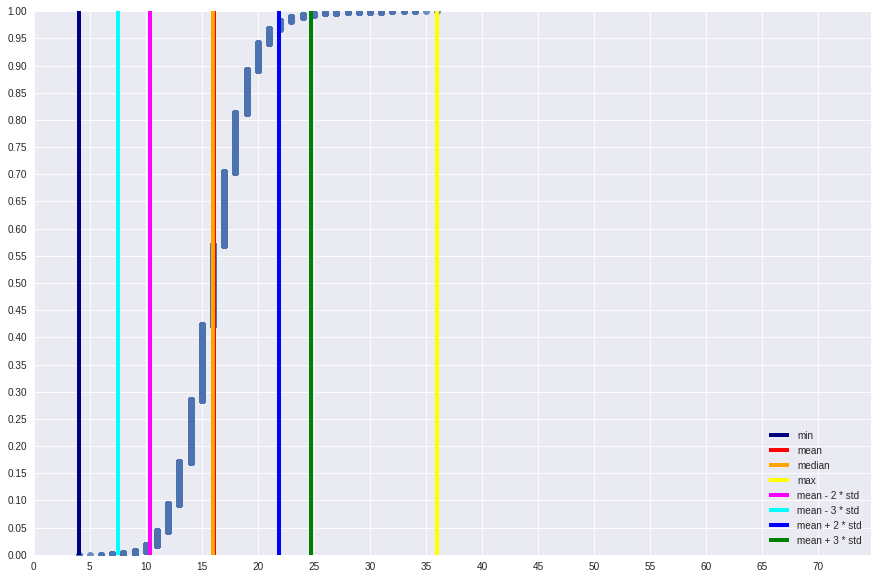

In [13]:
novel.plot_cdf_nb_tokens_in_passage()

#    To create word2vec, the parameters are used in Gensim
There are a few different sources instead of creating our word2vec model,
+ Google's pre-trained vectors based on GoogleNews
+ GLoVe's pre-trained vectors based on Wikipages
+ Spacy pre-trained vectors

I created our word2vec by using the corpus (test and train) on the top of Gensim.

In [14]:
# Load Google's pre-trained Word2Vec model.
novel._Novel__create_word2vec()

2017-06-04 18:37:45,718 : INFO : collecting all words and their counts
2017-06-04 18:37:45,719 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-06-04 18:37:45,795 : INFO : PROGRESS: at sentence #10000, processed 161672 words, keeping 20281 word types
2017-06-04 18:37:45,877 : INFO : PROGRESS: at sentence #20000, processed 322572 words, keeping 27130 word types


emb_dim:300_window:10_cbow:1_apha:0.05.bin doesn't exist. A new word2vec is being built...


2017-06-04 18:37:45,919 : INFO : PROGRESS: at sentence #30000, processed 483344 words, keeping 31551 word types
2017-06-04 18:37:45,974 : INFO : collected 33678 word types from a corpus of 575824 raw words and 35732 sentences
2017-06-04 18:37:45,975 : INFO : Loading a fresh vocabulary
2017-06-04 18:37:46,037 : INFO : min_count=5 retains 12307 unique words (36% of original 33678, drops 21371)
2017-06-04 18:37:46,038 : INFO : min_count=5 leaves 538581 word corpus (93% of original 575824, drops 37243)
2017-06-04 18:37:46,088 : INFO : deleting the raw counts dictionary of 33678 items
2017-06-04 18:37:46,090 : INFO : sample=0.001 downsamples 22 most-common words
2017-06-04 18:37:46,091 : INFO : downsampling leaves estimated 516531 word corpus (95.9% of prior 538581)
2017-06-04 18:37:46,092 : INFO : estimated required memory for 12307 words and 300 dimensions: 35690300 bytes
2017-06-04 18:37:46,160 : INFO : resetting layer weights
2017-06-04 18:37:46,338 : INFO : training model with 4 worker

#### A few example from our word2vec model

In [16]:
display(novel._Novel__word2vec.most_similar('fish'))
display(novel._Novel__word2vec.most_similar('sun'))
display(novel._Novel__word2vec.most_similar('world'))

[('oil', 0.9286333322525024),
 ('nantucket', 0.9082530736923218),
 ('keels', 0.9033700823783875),
 ('tail', 0.8938316106796265),
 ('harpooneer', 0.8918380737304688),
 ('sharks', 0.8895739316940308),
 ('harpooneers', 0.8811569809913635),
 ('captains', 0.8785420656204224),
 ('ships', 0.8772469162940979),
 ('line', 0.8763876557350159)]

[('sky', 0.9337055683135986),
 ('moon', 0.9249736666679382),
 ('darkness', 0.9208500385284424),
 ('snow', 0.9192581176757812),
 ('clouds', 0.9164905548095703),
 ('fresh', 0.9152648448944092),
 ('sunlight', 0.9152520895004272),
 ('stars', 0.9131763577461243),
 ('shadows', 0.9025346040725708),
 ('dim', 0.8914309144020081)]

[('living', 0.9281141757965088),
 ('souls', 0.8849952220916748),
 ('lives', 0.8612926602363586),
 ('conscience', 0.8409451246261597),
 ('holy', 0.8254971504211426),
 ('woe', 0.8211851716041565),
 ('creatures', 0.8201476335525513),
 ('angels', 0.8197317123413086),
 ('brain', 0.8187733888626099),
 ('mere', 0.817562460899353)]

#### Plotting a few random word by using T-SNE

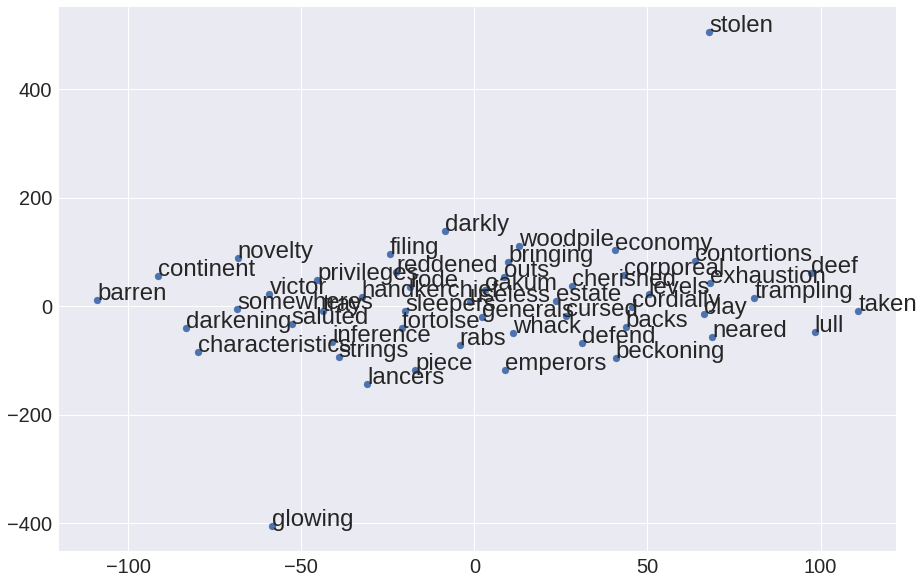

In [46]:
novel.plot_sample_word2vec()

# Pre-processing before Deep Learning by using Keras
+ Creating token vectors by using word2vec model
+ Creating sequence over token vectors
+ Creating embedding matrix over token vectors and word2vec model

In [17]:
novel._Novel__create_token_vectors()

x_train_corpus: 32732
x_test_corpus: 3000
train_tokens_vector: 32732
test_tokens_vector: 3000


In [26]:
novel._Novel__create_sequences()

x_train_padded: (32732, 50)
x_test_padded: (3000, 50)


In [22]:
novel._Novel__create_embedding_matrix()

Found 33674 unique tokens
Null word embeddings: 21371
embedding_matrix: (33675, 300)


#    Deep Learning Layers
Our network consists of the layers, below:
+ Embedding Layer
+ Dense Layer
+ LSTM for RNN Layer
+ Dense Layer

In [25]:
novel._Novel__create_nn()

init_weights shape: (array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  

In [66]:
# Tensorboard disable
novel.train()

clean_token and clean_corpus already have been calculated and loaded...
emb_dim:300_window:10_cbow:1_apha:0.05.bin has already loaded for word2vec...
train_token_vectors already have been calculated and loaded...
pad sequences already have been calculated and loaded...
embedding matrix already has been calculated and loaded...
Deep Learning Layers already has been built and loaded...
lstm_100_300_0.38_0.23.h5
Train on 29458 samples, validate on 3274 samples
Epoch 1/100
29458/29458 [==============================] - 243s - loss: 0.2088 - acc: 0.9372 - val_loss: 0.8074 - val_acc: 0.7755
Epoch 2/100
29458/29458 [==============================] - 139s - loss: 0.1673 - acc: 0.9509 - val_loss: 0.8821 - val_acc: 0.7688
Epoch 3/100
29458/29458 [==============================] - 129s - loss: 0.1385 - acc: 0.9594 - val_loss: 0.8535 - val_acc: 0.7783
Epoch 4/100
29458/29458 [==============================] - 131s - loss: 0.1155 - acc: 0.9666 - val_loss: 0.8926 - val_acc: 0.7776
Epoch 5/100
29458/

The best epoch is 3th since the lowest val_loss is occuring in that epoch

29458/29458 [==============================] - 129s - loss: 0.1385 - acc: 0.9594 - val_loss: 0.8535 - val_acc: 0.77

In [31]:
# Tensorboard enable
novel.train(True)

clean_token and clean_corpus already have been calculated and loaded...
emb_dim:300_window:10_cbow:1_apha:0.05.bin has already loaded for word2vec...
train_token_vectors already have been calculated and loaded...
pad sequences already have been calculated and loaded...
embedding matrix already has been calculated and loaded...
Deep Learning Layers already has been built and loaded...
lstm_100_300_0.38_0.26.h5
Train on 29458 samples, validate on 3274 samples
INFO:tensorflow:Summary name embedding_3/embeddings:0 is illegal; using embedding_3/embeddings_0 instead.


2017-06-04 19:25:49,684 : INFO : Summary name embedding_3/embeddings:0 is illegal; using embedding_3/embeddings_0 instead.


INFO:tensorflow:Summary name embedding_3/embeddings:0 is illegal; using embedding_3/embeddings_0 instead.


2017-06-04 19:25:49,695 : INFO : Summary name embedding_3/embeddings:0 is illegal; using embedding_3/embeddings_0 instead.


INFO:tensorflow:Summary name dense_3/kernel:0 is illegal; using dense_3/kernel_0 instead.


2017-06-04 19:25:49,700 : INFO : Summary name dense_3/kernel:0 is illegal; using dense_3/kernel_0 instead.


INFO:tensorflow:Summary name dense_3/kernel:0 is illegal; using dense_3/kernel_0 instead.


2017-06-04 19:25:49,708 : INFO : Summary name dense_3/kernel:0 is illegal; using dense_3/kernel_0 instead.


INFO:tensorflow:Summary name dense_3/bias:0 is illegal; using dense_3/bias_0 instead.


2017-06-04 19:25:49,712 : INFO : Summary name dense_3/bias:0 is illegal; using dense_3/bias_0 instead.


INFO:tensorflow:Summary name dense_3/bias:0 is illegal; using dense_3/bias_0 instead.


2017-06-04 19:25:49,725 : INFO : Summary name dense_3/bias:0 is illegal; using dense_3/bias_0 instead.


INFO:tensorflow:Summary name lstm_2/kernel:0 is illegal; using lstm_2/kernel_0 instead.


2017-06-04 19:25:49,730 : INFO : Summary name lstm_2/kernel:0 is illegal; using lstm_2/kernel_0 instead.


INFO:tensorflow:Summary name lstm_2/kernel:0 is illegal; using lstm_2/kernel_0 instead.


2017-06-04 19:25:49,734 : INFO : Summary name lstm_2/kernel:0 is illegal; using lstm_2/kernel_0 instead.


INFO:tensorflow:Summary name lstm_2/recurrent_kernel:0 is illegal; using lstm_2/recurrent_kernel_0 instead.


2017-06-04 19:25:49,736 : INFO : Summary name lstm_2/recurrent_kernel:0 is illegal; using lstm_2/recurrent_kernel_0 instead.


INFO:tensorflow:Summary name lstm_2/recurrent_kernel:0 is illegal; using lstm_2/recurrent_kernel_0 instead.


2017-06-04 19:25:49,743 : INFO : Summary name lstm_2/recurrent_kernel:0 is illegal; using lstm_2/recurrent_kernel_0 instead.


INFO:tensorflow:Summary name lstm_2/bias:0 is illegal; using lstm_2/bias_0 instead.


2017-06-04 19:25:49,745 : INFO : Summary name lstm_2/bias:0 is illegal; using lstm_2/bias_0 instead.


INFO:tensorflow:Summary name lstm_2/bias:0 is illegal; using lstm_2/bias_0 instead.


2017-06-04 19:25:49,751 : INFO : Summary name lstm_2/bias:0 is illegal; using lstm_2/bias_0 instead.


INFO:tensorflow:Summary name dense_4/kernel:0 is illegal; using dense_4/kernel_0 instead.


2017-06-04 19:25:49,754 : INFO : Summary name dense_4/kernel:0 is illegal; using dense_4/kernel_0 instead.


INFO:tensorflow:Summary name dense_4/kernel:0 is illegal; using dense_4/kernel_0 instead.


2017-06-04 19:25:49,761 : INFO : Summary name dense_4/kernel:0 is illegal; using dense_4/kernel_0 instead.


INFO:tensorflow:Summary name dense_4/bias:0 is illegal; using dense_4/bias_0 instead.


2017-06-04 19:25:49,763 : INFO : Summary name dense_4/bias:0 is illegal; using dense_4/bias_0 instead.


INFO:tensorflow:Summary name dense_4/bias:0 is illegal; using dense_4/bias_0 instead.


2017-06-04 19:25:49,769 : INFO : Summary name dense_4/bias:0 is illegal; using dense_4/bias_0 instead.


Epoch 1/100
29458/29458 [==============================] - 266s - loss: 0.2513 - acc: 0.9264 - val_loss: 0.7995 - val_acc: 0.7734
Epoch 2/100
29458/29458 [==============================] - 132s - loss: 0.2060 - acc: 0.9393 - val_loss: 0.8134 - val_acc: 0.7783
Epoch 3/100
29458/29458 [==============================] - 131s - loss: 0.1654 - acc: 0.9521 - val_loss: 0.8624 - val_acc: 0.7761
Epoch 4/100
29458/29458 [==============================] - 126s - loss: 0.1401 - acc: 0.9595 - val_loss: 0.8616 - val_acc: 0.7810
Epoch 5/100
29458/29458 [==============================] - 126s - loss: 0.1170 - acc: 0.9670 - val_loss: 0.8952 - val_acc: 0.7804


In [45]:
novel.test()

3000/3000 [==============================] - 53s     
The result was saved into file 'ytest.txt'


In [46]:
!head "ytest.txt"

1
7
7
3
7
11
7
6
7
6


In [55]:
labelled_passages = novel.labelled_pas
prediction_labels = list(map(lambda x : x[1], list(labelled_passages)))
prediction_labels

[[1, 0.9965539, 'dracula'],
 [7, 0.99933952, 'moby_dick'],
 [7, 0.97392827, 'moby_dick'],
 [3, 0.44632772, 'great_expectations'],
 [7, 0.99913472, 'moby_dick'],
 [11, 0.98463643, 'tom_sawyer'],
 [7, 0.99945062, 'moby_dick'],
 [6, 0.96079922, 'les_miserable'],
 [7, 0.45846087, 'moby_dick'],
 [6, 0.97793806, 'les_miserable'],
 [6, 0.94584048, 'les_miserable'],
 [5, 0.80798823, 'huckleberry_finn'],
 [4, 0.99750382, 'hard_times'],
 [10, 0.94205427, 'tale_of_two_cities'],
 [6, 0.81938559, 'les_miserable'],
 [4, 0.5993979, 'hard_times'],
 [3, 0.7346127, 'great_expectations'],
 [11, 0.56920904, 'tom_sawyer'],
 [7, 0.9947536, 'moby_dick'],
 [2, 0.98228443, 'dubliners'],
 [7, 0.99588686, 'moby_dick'],
 [1, 0.99329162, 'dracula'],
 [4, 0.28093511, 'hard_times'],
 [6, 0.99893922, 'les_miserable'],
 [4, 0.96715385, 'hard_times'],
 [9, 0.99777442, 'peter_pan'],
 [7, 0.99887305, 'moby_dick'],
 [4, 0.99345434, 'hard_times'],
 [4, 0.99762988, 'hard_times'],
 [4, 0.72023851, 'hard_times'],
 [3, 0.57429

# Model Evaluation 
Since we don't have labels value of the test dataset, I take care about CDF prob. of labels.
In this sense, the prob. is higher than 0.5 it is mostlike high accuracy when we compare the actual labels.
Our creteria will be focusing on weakly classified (< 0.5) whose probs is less than 0.5.

The following graphs is showing CDF of probs.
Number of test which has less 0.5 prob is 303 out of 3000. 
According to this assumption, it accurcy may be around 0.9. (a_acc = approximate accuracy, it is not actual. it just assumption on our CDF graphes)

In [65]:
p_of_0_5p = list(filter(lambda x: x[1][1] < 0.5, labelled_passages))
nb_of_0_5p = len(p_of_0_5p)
a_acc = 1 - nb_of_0_5p /len(labelled_passages)
a_acc

0.899

min:  0.169452
mean:  0.861214
median:  0.978369
max:  0.999691
mean - 2 * std:  0.452296853065
mean - 3 * std:  0.247838258743
mean + 2 * std:  1.27013123035
mean + 3 * std:  1.47458982468
min:  0.169452
mean:  0.861214
median:  0.978369
max:  0.999691
mean - 2 * std:  0.452296853065
mean - 3 * std:  0.247838258743
mean + 2 * std:  1.27013123035
mean + 3 * std:  1.47458982468
min:  0.169452
mean:  0.861214
median:  0.978369
max:  0.999691
mean - 2 * std:  0.452296853065
mean - 3 * std:  0.247838258743
mean + 2 * std:  1.27013123035
mean + 3 * std:  1.47458982468


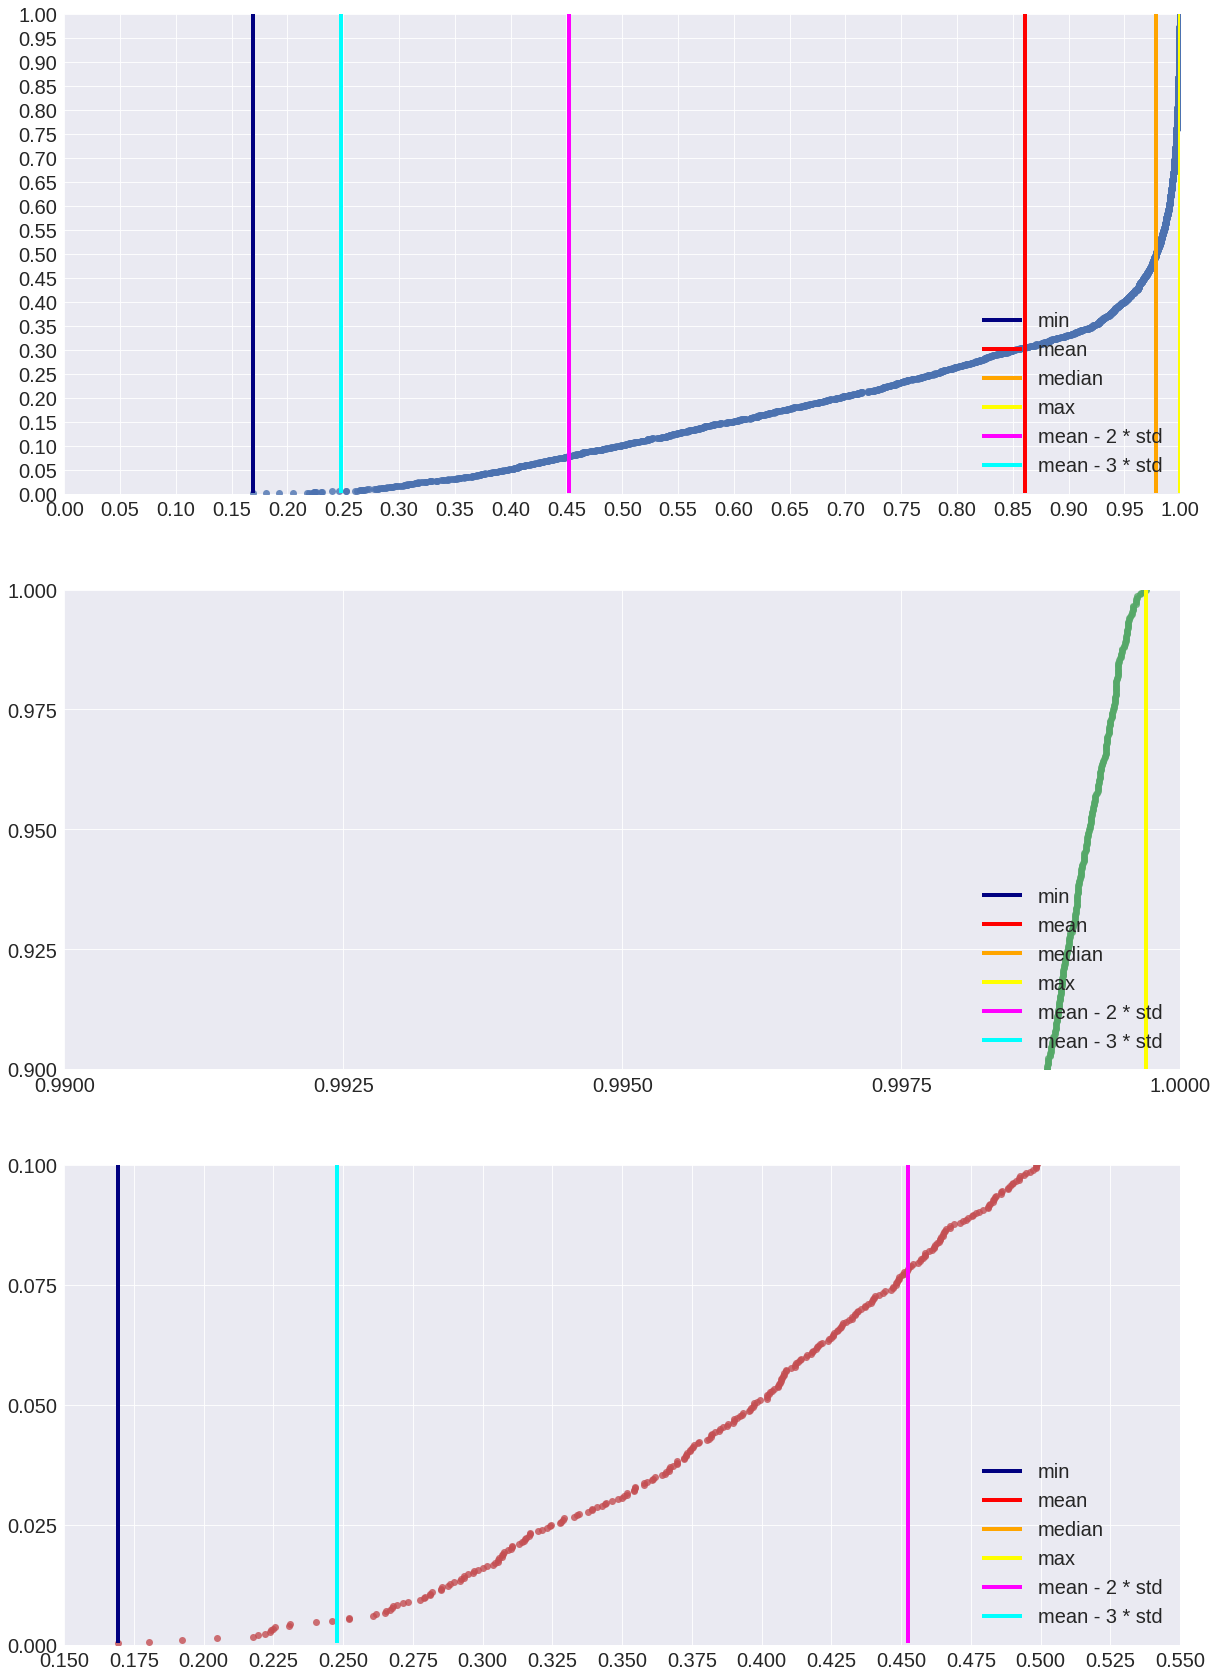

In [52]:
from Novel import NovelUtil
import matplotlib.pyplot as plt

pl = list(map(lambda x: x[1], prediction_labels))

x_pl, y_pl = NovelUtil.calculate_cdf(pl)

figure, axes = plt.subplots(3, figsize=(20,30))

NovelUtil.plot_cdf(x_pl, 
         y_pl,
         axes[0],
         deltax=0.05, 
         xlim=[0, 1],
         deltay = 0.05,
         ylim=[0, 1.00])

NovelUtil.plot_cdf(x_pl, 
         y_pl,
         axes[1],
         deltax=0.0025, 
         xlim=[0.99, 1],
         deltay = 0.025,
         ylim=[0.90, 1.00])


NovelUtil.plot_cdf(x_pl, 
         y_pl,
         axes[2],
         deltax=0.025, 
         xlim=[0.15, 0.55],
         deltay = 0.025,
         ylim=[0, 0.10])

In [56]:
list(filter(lambda x: 0.2 < x[1][1] and x[1][1] < 0.3, labelled_passages))

[('purpose, by its own sheer inveteracy of will, forced itself against gods and devils into a kind of self-assumed, independent being of its own. Nay, could grimly live and burn, while the common vitality to which it',
  [4, 0.28093511, 'hard_times']),
 ('asked if he had heard "voices" or "a voice," and he said he could not say; that at first it had seemed to him as if there were two, but as there was no one in the room it could have been only one. He could swear',
  [8, 0.27913174, 'oliver_twist']),
 ('but a page. It was appointed that the water should be locked in an eternal frost, when the light was playing on its surface, and I stood in ignorance on the shore. My friend is dead, my neighbour is dead,',
  [11, 0.28553113, 'tom_sawyer']),
 ('bring that about for themselves in the fulness of time, and if we step in to forestall them, it seems to me that we shall be performing a very Quixotic act, in direct opposition to our own interest--or at least to',
  [11, 0.21773829, 'tom_sawyer

In [ ]:
# score = model.evaluate([x_test_padded], y_test_label, verbose=0)
# print('Test score:', score[0])
# print('Test accuracy:', score[1])